## STATS 601 Project workspace

### Import Libraries
Note that pandas version has to be 1.4.x or higher and python version has to be 3.8.x or higher in order to read the pickle file.

In [1]:
!pip3 install numpy==1.22.1
!pip3 install pandas==1.4.1
!pip3 install matplotlib
!pip3 install sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=c4ad60d865459249f9be607f052aac25505d1a2c663de883df1d7b502be74492
  Stored in directory: \\engin-labs.m.storage.umich.edu\tywwyt\windat.v2\appdata\local\pip\cache\wheels\9b\13\01\6f3a7fd641f90e1f6c8c7cded057f3394f451f340371c68f3d
Successfully built sklearn


In [1]:
import os
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit

# !pip3 install bayesian-optimization
# import hyperparam
import critic

In [29]:
import ojsim
sim = ojsim.OJSimulator()
X,y = sim.formulized_train
X.shape, y.shape

((17709, 2, 1440, 10), (17709, 10))

In [36]:
def AllFeatureExtract(A):
    A0_pr = A[:,:1440]
    A0_vo = A[:,1440:]+1
    feature  = A0_pr[:,-1] - A0_pr[:,0]
    #VO volumn log
    feature = np.concatenate((feature[:,None], np.log(A0_vo)[:,-30:]), axis = 1)
    
    #VO difference vol (#sample, 31:60)
    diff_vol_step = 30
    diff_vol = A0_vo[:,diff_vol_step:] - A0_vo[:,:-diff_vol_step]
    feature = np.append(feature, diff_vol[:,-30:], axis = 1)
    
    #VO rate of change (#sample, 61:90)
    df_vo = pd.DataFrame(A0_vo.T)
    pct_chg_fxn = lambda x: x.pct_change()
    feature = np.append(feature,df_vo.apply(pct_chg_fxn).T.to_numpy()[:,-30:], axis = 1)
    
    #VO moving avg (#sample,91:120)
    avg_step = 30
    ma_30 = lambda x: x.rolling(avg_step).mean()
    df_vo.apply(ma_30).apply(np.log).T.to_numpy()[:,avg_step-1:]
    feature = np.append(feature,df_vo.apply(ma_30).apply(np.log).T.to_numpy()[:,-30:], axis = 1)
    
    #PR z_score (#sample, 121:150)
    z_score_min_period = 20
    df_pr = pd.DataFrame(A0_pr)
    zscore_fxn = lambda x: (x - x.mean()) / x.std()
    zscore_fun_improved =lambda x: (x - x.rolling(window=200, min_periods=z_score_min_period).mean())/ x.rolling(window=200, min_periods=z_score_min_period).std()
    df_pr.T.apply(zscore_fun_improved).T.to_numpy()[:,z_score_min_period-1:]
    feature = np.append(feature,df_pr.T.apply(zscore_fun_improved).T.to_numpy()[:,-30:], axis = 1)
    
    #VO binning (#sample, 151:180)
    n_bins = 10
    bin_fxn = lambda y: pd.qcut(y,q=n_bins,labels = range(1,n_bins+1))
    binning = df_vo.apply(bin_fxn).T
    feature = np.append(feature,binning.to_numpy()[:,-30:], axis = 1)
    
    #VO sign (#sample, 181:210)
    feature = np.append(feature,(df_vo.apply(pct_chg_fxn).apply(np.sign).to_numpy().T)[:,-30:], axis = 1)
    
    #VO plus-minus (#sample, 211:240)
    plus_minus_fxn = lambda x: x.rolling(20).sum()
    (df_vo.apply(pct_chg_fxn).apply(np.sign).to_numpy()[-30:,:]).T.shape
    feature = np.append(feature,(df_vo.apply(pct_chg_fxn).apply(np.sign).to_numpy()[-30:,:]).T, axis = 1)
    
    #PR difference (#sample, 241:270)
    diff_pr_step = 30
    diff_pr = A0_pr[:,diff_vol_step:] - A0_pr[:,:-diff_vol_step]
    #print("PR difference", A0_pr[:,diff_vol_step:] - A0_pr[:,:-diff_vol_step])
    feature = np.append(feature, diff_pr[:,-30:], axis = 1)
    
    #PR rate of change (#sample, 271:300)
    df_pr = pd.DataFrame(A0_pr.T)
    pct_chg_fxn = lambda x: x.pct_change()
    #print("PR rate of change", df_pr.apply(pct_chg_fxn).T.to_numpy()[:,-30:])
    feature = np.append(feature,df_pr.apply(pct_chg_fxn).T.to_numpy()[:,-30:], axis = 1)
    
    #PR moving avg (#sample,301:330)
    avg_step = 30
    ma_30 = lambda x: x.rolling(avg_step).mean()
    df_pr.apply(ma_30).T.to_numpy()[:,avg_step-1:]
    #print("PR moving avg", df_pr.apply(ma_30).T.to_numpy()[:,-30:])
    feature = np.append(feature,df_pr.apply(ma_30).T.to_numpy()[:,-30:], axis = 1) 
    
    #PR binning (#sample, 331:360)
    n_bins = 10
    bin_fxn = lambda y: pd.qcut(y,q=n_bins,labels = range(1,n_bins+1))
    binning = df_pr.apply(bin_fxn).T
    #print("PR binning", binning.to_numpy()[:,-30:])
    feature = np.append(feature,binning.to_numpy()[:,-30:], axis = 1)
    
    #PR sign (#sample, 361:390)
    #print("PR sign", (df_pr.apply(pct_chg_fxn).apply(np.sign).to_numpy().T)[:,-30:])
    feature = np.append(feature,(df_pr.apply(pct_chg_fxn).apply(np.sign).to_numpy().T)[:,-30:], axis = 1)
    
    #PR plus-minus (#sample, 391:420)
    plus_minus_fxn = lambda x: x.rolling(20).sum()
    #print("PR plus-minus", (df_pr.apply(pct_chg_fxn).apply(np.sign).to_numpy()[-30:,:]).T)
    feature = np.append(feature,(df_pr.apply(pct_chg_fxn).apply(np.sign).to_numpy()[-30:,:]).T, axis = 1)
    
    return feature

In [82]:
asset_num = 7
Y_train = y[:,asset_num]
input = np.concatenate((X[:,0,:,asset_num], X[:,1,:,asset_num]), axis = 1)  
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
X_train = AllFeatureExtract(input)
Y_train = y[:,asset_num]

[[0.0027591163082453427 12.38569718050323 12.633329656503417 ... 1.0 1.0
  -1.0]
 [0.004403154955420034 10.43892993469856 11.918278256237759 ... 1.0 1.0
  -1.0]
 [0.00478942136194767 12.488029207257481 12.003846125088653 ... -1.0 1.0
  1.0]
 ...
 [0.035322901580066984 12.19656309584971 12.556592092806685 ... -1.0 1.0
  1.0]
 [0.03475093625565484 11.69516911381277 11.620290794584896 ... 1.0 -1.0
  -1.0]
 [0.03800958496170853 11.658930061629839 11.17112007310433 ... 1.0 -1.0
  -1.0]] SelectKBest(k='all',
            score_func=<function mutual_info_regression at 0x000001720BCEB8B0>)
Feature 0: 0.440647
Feature 1: 0.076885
Feature 2: 0.064966
Feature 3: 0.071145
Feature 4: 0.082040
Feature 5: 0.078728
Feature 6: 0.081110
Feature 7: 0.085514
Feature 8: 0.083609
Feature 9: 0.070558
Feature 10: 0.080422
Feature 11: 0.076250
Feature 12: 0.062803
Feature 13: 0.076637
Feature 14: 0.080356
Feature 15: 0.065860
Feature 16: 0.085110
Feature 17: 0.079927
Feature 18: 0.083791
Feature 19: 0.080907
Fe

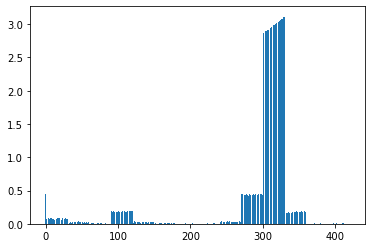

In [83]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2,mutual_info_regression
# configure to select all features
fs = SelectKBest(score_func=mutual_info_regression, k='all')
# learn relationship from training data
fs.fit(X_train, Y_train)
# transform train input data
X_train_fs = fs.transform(X_train)
print( X_train_fs, fs)
import matplotlib
import matplotlib.pyplot as plt
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

asset0 X_train[:,list(range(0, 31)) + list(range(91, 121)) + list(range(271, 361))]
asset1 X_train[:,list(range(0, 31)) + list(range(91, 121)) + list(range(271, 361))]
asset2 X_train[:,list(range(0, 61)) + list(range(91, 121)) + list(range(271, 331))]
asset3 X_train[:,list(range(0, 31)) + list(range(91, 121)) + list(range(271, 361))]
asset4 X_train[:,list(range(0, 31)) + list(range(91, 121)) + list(range(271, 361))]
asset5 X_train[:,list(range(0, 31)) + list(range(91, 121)) + list(range(271, 361))]
asset6 X_train[:,list(range(0, 31)) + list(range(91, 121)) + list(range(271, 361))]
asset7 X_train[:,list(range(0, 1)) + list(range(91, 121)) + list(range(271, 361))]
asset8 X_train[:,list(range(0, 1)) + list(range(271, 361))]
asset9 X_train[:,list(range(0, 1)) + list(range(271, 361))]

In [ ]:
X_input = X_train[:,list(range(0, 1)) + list(range(91, 121)) + list(range(271, 361))]


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
import pickle

reg = LinearRegression().fit(X_input, Y_train)
pickle.dump(reg, open(f'LR{asset_num}.plk', 'wb'))